In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import math
import gc
import copy

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor

In [2]:
DATA_PATH = '../input'
SUBMISSIONS_PATH = './'
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

In [4]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train_csv = pd.read_csv(f'{DATA_PATH}/train.csv', index_col='id', dtype=train_dtypes)
train_csv['molecule_index'] = train_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train_csv = train_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
train_csv.head(10)

C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,1,1,0,1JHC,84.807602
1,1,1,2,2JHH,-11.257000
2,1,1,3,2JHH,-11.254800
3,1,1,4,2JHH,-11.254300
4,1,2,0,1JHC,84.807404
5,1,2,3,2JHH,-11.254100
6,1,2,4,2JHH,-11.254800
7,1,3,0,1JHC,84.809303
8,1,3,4,2JHH,-11.254300


In [5]:
print(len(train_csv['molecule_index'].unique()))
print(train_csv.shape[0])
#df = pd.read_csv(f'{DATA_PATH}/train.csv', index_col='id', dtype=train_dtypes)
#df.head()

85003
4658147


In [6]:
print('Shape: ', train_csv.shape)
print('Total: ', train_csv.memory_usage().sum())
train_csv.memory_usage()

Shape:  (4658147, 5)
Total:  88505177


Index                       37265176
molecule_index              18632588
atom_index_0                4658147 
atom_index_1                4658147 
type                        4658531 
scalar_coupling_constant    18632588
dtype: int64

In [7]:
submission_csv = pd.read_csv(f'{DATA_PATH}/sample_submission.csv', index_col='id')

In [8]:
test_csv = pd.read_csv(f'{DATA_PATH}/test.csv', index_col='id', dtype=train_dtypes)
test_csv['molecule_index'] = test_csv['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test_csv = test_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]
test_csv.head(10)

,molecule_index,atom_index_0,atom_index_1,type
id,,,,
4658147,4,2,0,2JHC
4658148,4,2,1,1JHC
4658149,4,2,3,3JHH
4658150,4,3,0,1JHC
4658151,4,3,1,2JHC
4658152,15,3,0,1JHC
4658153,15,3,2,3JHC
4658154,15,3,4,2JHH
4658155,15,3,5,2JHH


In [9]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_csv = pd.read_csv(f'{DATA_PATH}/structures.csv', dtype=structures_dtypes)
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')
structures_csv.head(10)

,molecule_index,atom_index,atom,x,y,z
0,1,0,6,-0.012698,1.085804,0.008001
1,1,1,1,0.002150,-0.006031,0.001976
2,1,2,1,1.011731,1.463751,0.000277
3,1,3,1,-0.540815,1.447527,-0.876644
4,1,4,1,-0.523814,1.437933,0.906397
5,2,0,7,-0.040426,1.024108,0.062564
6,2,1,1,0.017257,0.012545,-0.027377
7,2,2,1,0.915789,1.358745,-0.028758
8,2,3,1,-0.520278,1.343532,-0.775543
9,3,0,8,-0.034360,0.977540,0.007602


In [10]:
print('Shape: ', structures_csv.shape)
print('Total: ', structures_csv.memory_usage().sum())
structures_csv.memory_usage()

Shape:  (2358657, 6)
Total:  42455906


Index             80     
molecule_index    9434628
atom_index        2358657
atom              2358657
x                 9434628
y                 9434628
z                 9434628
dtype: int64

In [11]:
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    return base, structures

In [12]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [13]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

In [14]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [15]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))

def add_distance_to_center(df):
    df['d_c'] = ((
        (df['x_c'] - df['x'])**np.float32(2) +
        (df['y_c'] - df['y'])**np.float32(2) + 
        (df['z_c'] - df['z'])**np.float32(2)
    )**np.float32(0.5))

def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [16]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [17]:
def add_n_atoms(base, structures):
    dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

In [18]:
def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

In [19]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    return df[labels]

In [20]:
%%time
full = build_couple_dataframe(train_csv, structures_csv, '1JHN', n_atoms=10)
print(full.shape)

(43363, 73)
Wall time: 1.59 s


In [21]:
full.head()

,id,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3
0,10,2,1,0,32.688900,0.017257,0.012545,-0.027377,-0.040426,1.024108,0.062564,1,1,0,0,0,0,0,0,0.915789,-0.520278,NaN,NaN,NaN,NaN,NaN,NaN,1.358745,1.343532,NaN,NaN,NaN,NaN,NaN,NaN,-0.028758,-0.775543,NaN,NaN,NaN,NaN,NaN,NaN,1.017190,1.618523,1.017187,1.618710,1.017208,1.618706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13,2,2,0,32.689098,0.915789,1.358745,-0.028758,-0.040426,1.024108,0.062564,1,1,0,0,0,0,0,0,0.017257,-0.520278,NaN,NaN,NaN,NaN,NaN,NaN,0.012545,1.343532,NaN,NaN,NaN,NaN,NaN,NaN,-0.027377,-0.775543,NaN,NaN,NaN,NaN,NaN,NaN,1.017187,1.618523,1.017190,1.618706,1.017208,1.618710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15,2,3,0,32.690498,-0.520278,1.343532,-0.775543,-0.040426,1.024108,0.062564,1,1,0,0,0,0,0,0,0.915789,0.017257,NaN,NaN,NaN,NaN,NaN,NaN,1.358745,0.012545,NaN,NaN,NaN,NaN,NaN,NaN,-0.028758,-0.027377,NaN,NaN,NaN,NaN,NaN,NaN,1.017208,1.618706,1.017187,1.618710,1.017190,1.618523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,97,12,3,0,55.525200,0.825355,1.885049,0.003738,-0.025900,1.346146,0.008894,1,6,8,1,0,0,0,0,-0.908377,0.046467,1.071835,-0.961441,NaN,NaN,NaN,NaN,1.826796,-0.011743,-0.652588,-0.475004,NaN,NaN,NaN,NaN,0.018920,0.001204,-0.011133,0.008074,NaN,NaN,NaN,NaN,1.007511,1.734777,1.004933,2.050487,1.359838,2.071779,2.549623,2.280430,3.173246,1.209220,2.960154,2.047394,2.302437,1.109295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,101,12,4,0,54.735901,-0.908377,1.826796,0.018920,-0.025900,1.346146,0.008894,1,6,1,8,0,0,0,0,0.825355,0.046467,-0.961441,1.071835,NaN,NaN,NaN,NaN,1.885049,-0.011743,-0.475004,-0.652588,NaN,NaN,NaN,NaN,0.003738,0.001204,0.008074,-0.011133,NaN,NaN,NaN,NaN,1.004933,1.734777,1.007511,2.071779,1.359838,2.050487,2.302437,2.047394,2.960154,1.109295,3.173246,2.280430,2.549623,1.209220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df = take_n_atoms(full, 7)
# LightGBM performs better with 0-s then with NaN-s
df = df.fillna(0)
df.columns

Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'scalar_coupling_constant'],
      dtype='object')

In [36]:
df.head()

,atom_2,atom_3,atom_4,atom_5,atom_6,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,scalar_coupling_constant
0,1,1,0,0,0,1.017190,1.618523,1.017187,1.618710,1.017208,1.618706,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,32.688900
1,1,1,0,0,0,1.017187,1.618523,1.017190,1.618706,1.017208,1.618710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,32.689098
2,1,1,0,0,0,1.017208,1.618706,1.017187,1.618710,1.017190,1.618523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,32.690498
3,1,6,8,1,0,1.007511,1.734777,1.004933,2.050487,1.359838,2.071779,2.549623,2.280430,3.173246,1.209220,2.960154,2.047394,2.302437,1.109295,0.0,0.0,0.0,0.0,55.525200
4,1,6,1,8,0,1.004933,1.734777,1.007511,2.071779,1.359838,2.050487,2.302437,2.047394,2.960154,1.109295,3.173246,2.280430,2.549623,1.209220,0.0,0.0,0.0,0.0,54.735901


In [37]:
X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
y_data = df['scalar_coupling_constant'].values.astype('float32')

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=128)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((34690, 23), (8673, 23), (34690,), (8673,))

In [70]:
# configuration params are copied from @artgor kernel:
# https://www.kaggle.com/artgor/brute-force-feature-engineering
LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'num_leaves': 128,
    'min_child_samples': 79,
    'max_depth': 9,
    'subsample_freq': 1,
    'subsample': 0.8,
    'bagging_seed': 11,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'colsample_bytree': 1.0
}

In [39]:
model = LGBMRegressor(**LGB_PARAMS, n_estimators=1500, n_jobs = -1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=200)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.427416	valid_1's l1: 0.530836
[200]	training's l1: 0.350459	valid_1's l1: 0.478417
[300]	training's l1: 0.303456	valid_1's l1: 0.452326
[400]	training's l1: 0.269533	valid_1's l1: 0.435638
[500]	training's l1: 0.243628	valid_1's l1: 0.424128
[600]	training's l1: 0.220787	valid_1's l1: 0.415888
[700]	training's l1: 0.203385	valid_1's l1: 0.410255
[800]	training's l1: 0.188507	valid_1's l1: 0.404904
[900]	training's l1: 0.174816	valid_1's l1: 0.401067
[1000]	training's l1: 0.16275	valid_1's l1: 0.397243
[1100]	training's l1: 0.152674	valid_1's l1: 0.39465
[1200]	training's l1: 0.143063	valid_1's l1: 0.392683
[1300]	training's l1: 0.1345	valid_1's l1: 0.390672
[1400]	training's l1: 0.126628	valid_1's l1: 0.388991
[1500]	training's l1: 0.119411	valid_1's l1: 0.387634
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.119411	valid_1's l1: 0.387634


-0.9476949111999775

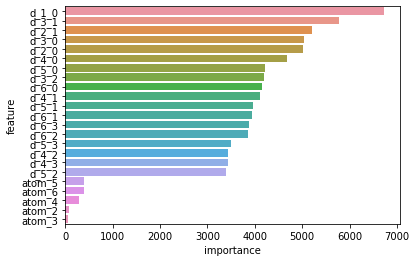

In [40]:
cols = list(df.columns)
cols.remove('scalar_coupling_constant')
cols
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

In [23]:
def build_x_y_data(some_csv, coupling_type, n_atoms):
    full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=n_atoms)
    
    df = take_n_atoms(full, n_atoms)
    df = df.fillna(df.mean())
    print(df.columns)
    from IPython.display import display
    display(df.head())
    
    if 'scalar_coupling_constant' in df:
        X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
        y_data = df['scalar_coupling_constant'].values.astype('float32')
    else:
        X_data = df.values.astype('float32')
        y_data = None
    
    return X_data, y_data

In [24]:
def train_and_predict_for_one_coupling_type(coupling_type, submission, n_atoms, n_folds=5, n_splits=5, random_state=128):
    print(f'*** Training Model for {coupling_type} ***')
    
    X_data, y_data = build_x_y_data(train_csv, coupling_type, n_atoms)
    X_test, _ = build_x_y_data(test_csv, coupling_type, n_atoms)
    y_pred = np.zeros(X_test.shape[0], dtype='float32')

    cv_score = 0
    
    if n_folds > n_splits:
        n_splits = n_folds
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data, y_data)):
        if fold >= n_folds:
            break

        X_train, X_val = X_data[train_index], X_data[val_index]
        y_train, y_val = y_data[train_index], y_data[val_index]

        model = LGBMRegressor(**LGB_PARAMS, n_estimators=1500, n_jobs = -1)
        model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
            verbose=100, early_stopping_rounds=200)

        y_val_pred = model.predict(X_val)
        val_score = np.log(mean_absolute_error(y_val, y_val_pred))
        print(f'{coupling_type} Fold {fold}, logMAE: {val_score}')
        
        cv_score += val_score / n_folds
        y_pred += model.predict(X_test) / n_folds
        
        
    submission.loc[test_csv['type'] == coupling_type, 'scalar_coupling_constant'] = y_pred
    return cv_score

In [28]:
test_csv.head()

,molecule_index,atom_index_0,atom_index_1,type
id,,,,
4658147,4,2,0,2JHC
4658148,4,2,1,1JHC
4658149,4,2,3,3JHH
4658150,4,3,0,1JHC
4658151,4,3,1,2JHC


In [27]:
submission_csv.loc[test_csv['type'] == '1JHN', 'scalar_coupling_constant']

id
4658203    0
4658207    0
4658212    0
4658216    0
4658303    0
4658548    0
4658552    0
4658750    0
4658754    0
4658771    0
4658796    0
4658799    0
4658959    0
4658973    0
4659208    0
4659291    0
4659318    0
4659442    0
4659580    0
4659733    0
4659749    0
4659770    0
4659771    0
4659776    0
4659804    0
4659805    0
4659809    0
4659875    0
4659880    0
4659893    0
4659902    0
4659907    0
4659926    0
4659931    0
4659955    0
4660478    0
4660489    0
4660504    0
4660510    0
4660514    0
4660531    0
4660535    0
4660540    0
4660551    0
4660552    0
4660556    0
4660561    0
4660824    0
4660870    0
4660875    0
4660879    0
4660903    0
4660906    0
4661308    0
4661313    0
4661315    0
4661320    0
4661324    0
4661328    0
4661333    0
          ..
7158837    0
7158840    0
7158860    0
7158866    0
7158872    0
7158876    0
7158880    0
7158887    0
7158895    0
7158897    0
7158900    0
7158905    0
7158909    0
7158917    0
7158923    0
7158926  

In [83]:
model_params = {
    '1JHN': 7,
    '1JHC': 10,
    '2JHH': 9,
    '2JHN': 9,
    '2JHC': 9,
    '3JHH': 9,
    '3JHC': 10,
    '3JHN': 10
}
N_FOLDS = 3
submission = submission_csv.copy()

cv_scores = {}
for coupling_type in model_params.keys():
    cv_score = train_and_predict_for_one_coupling_type(
        coupling_type, submission, n_atoms=model_params[coupling_type], n_folds=N_FOLDS)
    cv_scores[coupling_type] = cv_score

*** Training Model for 1JHN ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'scalar_coupling_constant'],
      dtype='object')


,atom_2,atom_3,atom_4,atom_5,atom_6,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,scalar_coupling_constant
0,1,1,0,0,0,1.017190,1.618523,1.017187,1.618710,1.017208,1.618706,2.567342,2.301477,2.522583,1.747083,2.844029,2.453634,2.503238,2.061651,3.138544,2.603128,2.55821,2.146745,32.688900
1,1,1,0,0,0,1.017187,1.618523,1.017190,1.618706,1.017208,1.618710,2.567342,2.301477,2.522583,1.747083,2.844029,2.453634,2.503238,2.061651,3.138544,2.603128,2.55821,2.146745,32.689098
2,1,1,0,0,0,1.017208,1.618706,1.017187,1.618710,1.017190,1.618523,2.567342,2.301477,2.522583,1.747083,2.844029,2.453634,2.503238,2.061651,3.138544,2.603128,2.55821,2.146745,32.690498
3,1,6,8,1,0,1.007511,1.734777,1.004933,2.050487,1.359838,2.071779,2.549623,2.280430,3.173246,1.209220,2.960154,2.047394,2.302437,1.109295,3.138544,2.603128,2.55821,2.146745,55.525200
4,1,6,1,8,0,1.004933,1.734777,1.007511,2.071779,1.359838,2.050487,2.302437,2.047394,2.960154,1.109295,3.173246,2.280430,2.549623,1.209220,3.138544,2.603128,2.55821,2.146745,54.735901


Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3'],
      dtype='object')


,atom_2,atom_3,atom_4,atom_5,atom_6,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3
0,1,6,7,1,8,1.009036,1.692657,1.008709,2.058837,1.388677,2.005497,2.500374,2.323178,3.196560,1.388684,2.425488,2.500337,3.493074,2.058839,3.122215,2.290673,2.454517,1.213296
1,1,6,8,7,1,1.008709,1.692657,1.009036,2.005497,1.388677,2.058837,2.454517,2.290673,3.122215,1.213296,3.196560,2.323178,2.500374,1.388684,3.493074,2.500337,2.425488,2.058839
2,1,6,7,1,8,1.009039,1.692645,1.008711,2.058839,1.388684,2.005485,2.500337,2.323178,3.196526,1.388677,2.425488,2.500374,3.493103,2.058837,3.122188,2.290677,2.454483,1.213296
3,1,6,8,7,1,1.008711,1.692645,1.009039,2.005485,1.388684,2.058839,2.454483,2.290677,3.122188,1.213296,3.196526,2.323178,2.500337,1.388677,3.493103,2.500374,2.425488,2.058837
4,6,6,1,1,1,1.006898,2.036088,1.359758,2.131299,1.450853,2.469262,2.241897,2.044861,1.108430,3.403296,2.532606,2.112616,3.191004,1.095453,2.533398,2.112602,3.191009,1.095451


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.433461	valid_1's l1: 0.528164
[200]	training's l1: 0.363673	valid_1's l1: 0.480942
[300]	training's l1: 0.316831	valid_1's l1: 0.45466
[400]	training's l1: 0.281453	valid_1's l1: 0.437246
[500]	training's l1: 0.255591	valid_1's l1: 0.425259
[600]	training's l1: 0.234064	valid_1's l1: 0.416357
[700]	training's l1: 0.214723	valid_1's l1: 0.408414
[800]	training's l1: 0.198318	valid_1's l1: 0.403553
[900]	training's l1: 0.185411	valid_1's l1: 0.399412
[1000]	training's l1: 0.171846	valid_1's l1: 0.395507
[1100]	training's l1: 0.15978	valid_1's l1: 0.392412
[1200]	training's l1: 0.149784	valid_1's l1: 0.389586
[1300]	training's l1: 0.14055	valid_1's l1: 0.387349
[1400]	training's l1: 0.131849	valid_1's l1: 0.38544
[1500]	training's l1: 0.123992	valid_1's l1: 0.384151
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.123992	valid_1's l1: 0.384151
1JHN Fold 0, logMAE: -0.95671933785664

,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3,scalar_coupling_constant
0,1,1,1,0,0,0,0,0,1.091953,1.783120,1.091952,1.783147,1.091946,1.783158,1.783157,1.091948,1.783148,1.783148,2.619035,2.303248,2.891396,2.462783,2.804069,2.442042,2.979263,2.515719,3.013238,2.552886,2.984184,2.604331,3.200961,2.706883,3.081471,2.742807,3.398124,2.878346,3.210239,2.882235,84.807602
1,1,1,1,0,0,0,0,0,1.091952,1.783120,1.091953,1.783148,1.091948,1.783157,1.783158,1.091946,1.783147,1.783148,2.619035,2.303248,2.891396,2.462783,2.804069,2.442042,2.979263,2.515719,3.013238,2.552886,2.984184,2.604331,3.200961,2.706883,3.081471,2.742807,3.398124,2.878346,3.210239,2.882235,84.807404
2,1,1,1,0,0,0,0,0,1.091946,1.783148,1.091948,1.783147,1.091953,1.783157,1.783158,1.091952,1.783148,1.783120,2.619035,2.303248,2.891396,2.462783,2.804069,2.442042,2.979263,2.515719,3.013238,2.552886,2.984184,2.604331,3.200961,2.706883,3.081471,2.742807,3.398124,2.878346,3.210239,2.882235,84.809303
3,1,1,1,0,0,0,0,0,1.091948,1.783148,1.091946,1.783148,1.091952,1.783158,1.783157,1.091953,1.783147,1.783120,2.619035,2.303248,2.891396,2.462783,2.804069,2.442042,2.979263,2.515719,3.013238,2.552886,2.984184,2.604331,3.200961,2.706883,3.081471,2.742807,3.398124,2.878346,3.210239,2.882235,84.809502
4,7,0,0,0,0,0,0,0,1.066598,2.218346,1.151748,2.070286,1.387729,2.065054,2.251851,1.602644,2.217791,2.183622,2.619035,2.303248,2.891396,2.462783,2.804069,2.442042,2.979263,2.515719,3.013238,2.552886,2.984184,2.604331,3.200961,2.706883,3.081471,2.742807,3.398124,2.878346,3.210239,2.882235,171.220001


Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0',
       'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0',
       'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0',
       'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3'],
      dtype='object')


,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3
0,6,1,0,0,0,0,0,0,1.062099,2.261178,1.199079,3.323277,2.261178,1.062099,2.256620,1.602914,2.223439,2.187649,2.618383,2.306185,2.888478,2.461524,2.803414,2.445045,2.978278,2.513245,3.012419,2.556051,2.985054,2.605011,3.200176,2.708520,3.083592,2.741680,3.397988,2.879126,3.208583,2.881782
1,6,1,0,0,0,0,0,0,1.062099,2.261178,1.199079,3.323277,2.261178,1.062099,2.256620,1.602914,2.223439,2.187649,2.618383,2.306185,2.888478,2.461524,2.803414,2.445045,2.978278,2.513245,3.012419,2.556051,2.985054,2.605011,3.200176,2.708520,3.083592,2.741680,3.397988,2.879126,3.208583,2.881782
2,1,1,8,6,1,1,1,0,1.102328,1.785017,1.092852,1.782964,1.102327,1.785001,2.084781,1.406083,2.023622,2.084783,2.640324,2.337653,3.262566,2.639910,2.461969,2.639962,3.624740,3.039153,3.040306,2.640269,3.624693,2.461848,3.624762,3.262567,4.042522,3.624674,3.397988,2.879126,3.208583,2.881782
3,1,1,8,6,1,1,1,0,1.102327,1.785001,1.092852,1.782964,1.102328,1.785017,2.084783,1.406083,2.023622,2.084781,2.639910,2.337653,3.262566,2.640324,2.461848,2.640269,3.624693,3.040306,3.039153,2.639962,3.624740,2.461969,3.624674,3.262567,4.042522,3.624762,3.397988,2.879126,3.208583,2.881782
4,1,1,8,6,1,1,1,0,1.092852,1.785001,1.102327,1.785017,1.102328,1.782964,2.023622,1.406083,2.084783,2.084781,3.262566,2.337653,2.639910,2.640324,3.624740,2.639962,3.039153,2.461969,3.624693,2.640269,2.461848,3.040306,4.042522,3.262567,3.624674,3.624762,3.397988,2.879126,3.208583,2.881782


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 1.17001	valid_1's l1: 1.21987
[200]	training's l1: 0.997311	valid_1's l1: 1.07615
[300]	training's l1: 0.897825	valid_1's l1: 1.00246
[400]	training's l1: 0.83053	valid_1's l1: 0.955953
[500]	training's l1: 0.778743	valid_1's l1: 0.923487
[600]	training's l1: 0.735768	valid_1's l1: 0.897296
[700]	training's l1: 0.699316	valid_1's l1: 0.875651
[800]	training's l1: 0.668001	valid_1's l1: 0.858814
[900]	training's l1: 0.641461	valid_1's l1: 0.844891
[1000]	training's l1: 0.616834	valid_1's l1: 0.832086
[1100]	training's l1: 0.595495	valid_1's l1: 0.821657
[1200]	training's l1: 0.575415	valid_1's l1: 0.812066
[1300]	training's l1: 0.557376	valid_1's l1: 0.803702
[1400]	training's l1: 0.540057	valid_1's l1: 0.796061
[1500]	training's l1: 0.52397	valid_1's l1: 0.789025
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.52397	valid_1's l1: 0.789025
1JHC Fold 0, logMAE: -0.2369575651916571


,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,scalar_coupling_constant
0,6,1,1,0,0,0,0,1.783120,1.091953,1.091952,1.783157,1.783148,1.091948,1.783147,1.783158,1.091946,1.783148,2.718966,2.746641,2.376758,2.881819,2.917112,2.919235,2.488621,2.808076,3.091246,3.081742,2.635679,2.870413,3.260059,3.278833,2.822999,2.988661,-11.2570
1,6,1,1,0,0,0,0,1.783147,1.091953,1.091946,1.783120,1.783158,1.091952,1.783157,1.783148,1.091948,1.783148,2.718966,2.746641,2.376758,2.881819,2.917112,2.919235,2.488621,2.808076,3.091246,3.081742,2.635679,2.870413,3.260059,3.278833,2.822999,2.988661,-11.2548
3,6,1,1,0,0,0,0,1.783157,1.091953,1.091948,1.783120,1.783148,1.091952,1.783147,1.783148,1.091946,1.783158,2.718966,2.746641,2.376758,2.881819,2.917112,2.919235,2.488621,2.808076,3.091246,3.081742,2.635679,2.870413,3.260059,3.278833,2.822999,2.988661,-11.2543
2,6,1,1,0,0,0,0,1.783158,1.091952,1.091946,1.783120,1.783147,1.091953,1.783148,1.783148,1.091948,1.783157,2.718966,2.746641,2.376758,2.881819,2.917112,2.919235,2.488621,2.808076,3.091246,3.081742,2.635679,2.870413,3.260059,3.278833,2.822999,2.988661,-11.2541
4,6,1,1,0,0,0,0,1.783148,1.091952,1.091948,1.783120,1.783157,1.091953,1.783158,1.783148,1.091946,1.783147,2.718966,2.746641,2.376758,2.881819,2.917112,2.919235,2.488621,2.808076,3.091246,3.081742,2.635679,2.870413,3.260059,3.278833,2.822999,2.988661,-11.2548


Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3'],
      dtype='object')


,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3
0,6,1,8,6,1,1,1,1.782964,1.102328,1.102327,1.785017,1.785001,1.092852,2.084781,2.084783,1.406083,2.023622,2.640324,2.639910,2.337653,3.262566,2.461969,3.039153,2.639962,3.624740,3.040306,2.461848,2.640269,3.624693,3.624762,3.624674,3.262567,4.042522
1,6,1,8,6,1,1,1,1.785017,1.102328,1.092852,1.782964,1.785001,1.102327,2.084781,2.023622,1.406083,2.084783,2.640324,3.262566,2.337653,2.639910,2.461969,3.624740,2.639962,3.039153,3.040306,3.624693,2.640269,2.461848,3.624762,4.042522,3.262567,3.624674
2,6,1,8,6,1,1,1,1.785001,1.102327,1.092852,1.782964,1.785017,1.102328,2.084783,2.023622,1.406083,2.084781,2.639910,3.262566,2.337653,2.640324,2.461848,3.624693,2.640269,3.040306,3.039153,3.624740,2.639962,2.461969,3.624674,4.042522,3.262567,3.624762
3,6,1,8,6,1,1,1,1.782964,1.102327,1.102328,1.785017,1.785001,1.092852,2.084777,2.084785,1.406083,2.023623,2.640269,2.639962,2.337653,3.262567,2.461848,3.039153,2.639910,3.624674,3.040306,2.461969,2.640324,3.624762,3.624693,3.624740,3.262566,4.042522
4,6,1,8,6,1,1,1,1.785017,1.102327,1.092852,1.782964,1.785001,1.102328,2.084777,2.023623,1.406083,2.084785,2.640269,3.262567,2.337653,2.639962,2.461848,3.624674,2.639910,3.039153,3.040306,3.624762,2.640324,2.461969,3.624693,4.042522,3.262566,3.624740


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.257657	valid_1's l1: 0.281496
[200]	training's l1: 0.211609	valid_1's l1: 0.246302
[300]	training's l1: 0.186471	valid_1's l1: 0.228962
[400]	training's l1: 0.169972	valid_1's l1: 0.218892
[500]	training's l1: 0.156885	valid_1's l1: 0.211541
[600]	training's l1: 0.146135	valid_1's l1: 0.205755
[700]	training's l1: 0.137186	valid_1's l1: 0.201301
[800]	training's l1: 0.129893	valid_1's l1: 0.197702
[900]	training's l1: 0.123093	valid_1's l1: 0.194594
[1000]	training's l1: 0.117291	valid_1's l1: 0.1922
[1100]	training's l1: 0.112073	valid_1's l1: 0.189933
[1200]	training's l1: 0.10727	valid_1's l1: 0.187904
[1300]	training's l1: 0.102614	valid_1's l1: 0.186175
[1400]	training's l1: 0.0982285	valid_1's l1: 0.184575
[1500]	training's l1: 0.0943475	valid_1's l1: 0.18312
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0943475	valid_1's l1: 0.18312
2JHH Fold 0, logMAE: -1.697612938668

,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,scalar_coupling_constant
0,6,0,0,0,0,0,0,2.218346,1.066598,1.151748,2.118863,1.757199,1.503593,2.339861,1.869114,1.661175,2.402384,2.660600,1.945294,2.074429,2.431555,2.962953,2.066252,2.403194,2.641667,3.124807,2.474733,2.648099,2.913198,3.357145,2.696783,2.856125,3.188003,5.182460
1,6,1,8,1,0,0,0,2.047394,1.109295,1.359838,2.302437,1.004933,2.071779,2.041107,2.280430,1.209220,3.173246,2.960154,1.007511,2.050487,1.734777,2.962953,2.066252,2.403194,2.641667,3.124807,2.474733,2.648099,2.913198,3.357145,2.696783,2.856125,3.188003,15.513500
2,6,1,1,1,6,7,0,2.178272,1.102846,1.463593,2.462809,1.015277,2.046443,2.474020,1.014969,2.035264,1.631013,1.763417,2.088941,1.096093,2.937592,2.081279,2.412301,1.467535,2.674642,3.123002,3.430577,2.622283,3.536521,3.357145,2.696783,2.856125,3.188003,0.633806
3,6,1,1,1,6,7,0,2.088941,1.096093,1.463593,2.359597,1.014969,2.035264,1.763417,2.178272,1.102846,2.474020,2.937592,1.015277,2.046443,1.631013,2.083812,2.412301,1.467535,3.285424,3.143254,3.430577,2.622283,4.368732,3.357145,2.696783,2.856125,3.188003,1.378300
4,8,6,6,1,1,6,1,1.862592,0.962687,1.407620,2.974144,1.278454,2.220291,3.580907,2.458436,2.630615,1.505876,3.509423,2.782271,2.589377,2.148371,3.558800,2.803989,2.637955,2.148513,4.228567,2.368134,3.621140,1.501380,4.242843,2.460604,3.859436,2.143993,0.784661


Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3'],
      dtype='object')


,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3
0,6,1,1,1,6,8,1,2.112602,1.095451,1.450853,1.780200,2.057123,1.090538,2.533398,1.006898,2.131299,2.969499,1.780478,2.112616,1.095453,1.780248,3.191009,1.359758,2.469262,2.514581,3.610494,2.287575,2.860947,2.402916,4.039468,2.044861,3.403296,3.601052
1,6,1,1,1,6,8,1,2.112616,1.095453,1.450853,1.780248,2.057123,1.090538,2.532606,1.006898,2.131299,2.969499,1.780478,2.112602,1.095451,1.780200,3.191004,1.359758,2.469262,2.514581,3.610818,2.287575,2.860947,2.402916,4.039211,2.044861,3.403296,3.601052
2,6,1,1,6,1,8,1,2.057123,1.090538,1.450853,1.780200,2.112602,1.095451,1.780248,2.112616,1.095453,1.780478,2.514581,1.359758,2.469262,3.191009,2.969499,1.006898,2.131299,2.533398,2.402916,2.287575,2.860947,3.610494,3.601052,2.044861,3.403296,4.039468
3,6,1,8,6,1,1,1,2.044861,1.108430,1.359758,2.241897,1.006898,2.036088,2.040690,2.287575,1.212531,3.154423,3.403296,1.450853,2.469262,2.131299,3.601052,2.057123,2.514581,2.969499,4.039211,2.112616,3.191004,2.532606,4.039468,2.112602,3.191009,2.533398
4,6,1,1,6,6,1,1,2.147459,1.104385,1.455066,1.781333,2.091117,1.094826,1.781332,2.091118,1.094826,1.773919,2.640964,1.457989,2.470816,2.940124,2.640965,1.457989,2.470814,3.359663,2.397472,2.191368,2.630144,2.980894,2.397475,2.191368,2.630142,3.644807


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.187955	valid_1's l1: 0.219635
[200]	training's l1: 0.153218	valid_1's l1: 0.194556
[300]	training's l1: 0.133899	valid_1's l1: 0.182736
[400]	training's l1: 0.119355	valid_1's l1: 0.174407
[500]	training's l1: 0.108042	valid_1's l1: 0.169066
[600]	training's l1: 0.0990768	valid_1's l1: 0.164644
[700]	training's l1: 0.0912459	valid_1's l1: 0.160959
[800]	training's l1: 0.0847576	valid_1's l1: 0.158163
[900]	training's l1: 0.0790692	valid_1's l1: 0.156046
[1000]	training's l1: 0.0738701	valid_1's l1: 0.154171
[1100]	training's l1: 0.0693026	valid_1's l1: 0.152305
[1200]	training's l1: 0.0654792	valid_1's l1: 0.151088
[1300]	training's l1: 0.0616717	valid_1's l1: 0.149721
[1400]	training's l1: 0.0583555	valid_1's l1: 0.148652
[1500]	training's l1: 0.0554182	valid_1's l1: 0.147687
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0554182	valid_1's l1: 0.147687
2JHN Fold 0, logMAE: -1

,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,scalar_coupling_constant
0,6,1,1,1,1,1,0,2.182492,1.094954,1.529629,2.543341,1.094958,2.182485,2.543368,1.094968,2.182537,1.765251,1.765219,2.182487,1.094958,3.095900,1.765264,2.182539,1.094968,2.543377,3.09590,1.094953,2.182485,1.765220,3.102134,2.449793,2.660158,2.994153,-2.37831
1,6,1,1,1,1,1,0,2.182487,1.094958,1.529629,2.543345,1.094953,2.182485,2.543366,1.094968,2.182537,1.765268,1.765219,2.182492,1.094954,3.095900,1.765247,2.182539,1.094968,2.543351,3.09590,1.094958,2.182485,1.765220,3.102134,2.449793,2.660158,2.994153,-2.37862
2,6,1,1,1,1,1,0,2.182539,1.094968,1.529629,2.543351,1.094953,2.182485,2.543377,1.094958,2.182485,1.765220,1.765247,2.182487,1.094958,2.543345,1.765264,2.182492,1.094954,3.095900,3.09598,1.094968,2.182537,1.765268,3.102134,2.449793,2.660158,2.994153,-2.37716
3,6,1,1,1,1,1,0,2.182485,1.094958,1.529629,2.543341,1.094954,2.182492,2.543377,1.094968,2.182539,1.765264,1.765220,2.182485,1.094953,3.095900,1.765251,2.182537,1.094968,2.543368,3.09590,1.094958,2.182487,1.765219,3.102134,2.449793,2.660158,2.994153,-2.37876
4,6,1,1,1,1,1,0,2.182485,1.094953,1.529629,2.543345,1.094958,2.182487,2.543351,1.094968,2.182539,1.765247,1.765220,2.182485,1.094958,3.095900,1.765268,2.182537,1.094968,2.543366,3.09590,1.094954,2.182492,1.765219,3.102134,2.449793,2.660158,2.994153,-2.37852


Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3'],
      dtype='object')


,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3
0,6,1,0,0,0,0,0,2.261178,1.062099,1.199079,3.323277,1.062099,2.261178,2.278564,1.808718,1.738975,2.506275,2.557176,1.828243,1.999623,2.610008,2.809501,1.864113,2.243306,2.618530,2.978516,2.079928,2.439420,2.722504,3.104297,2.446390,2.658495,2.998814
1,6,1,0,0,0,0,0,2.261178,1.062099,1.199079,3.323277,1.062099,2.261178,2.278564,1.808718,1.738975,2.506275,2.557176,1.828243,1.999623,2.610008,2.809501,1.864113,2.243306,2.618530,2.978516,2.079928,2.439420,2.722504,3.104297,2.446390,2.658495,2.998814
2,6,6,1,1,1,1,1,2.233319,1.084473,1.506721,2.233532,1.506676,1.506825,2.529971,1.084467,2.233464,2.233147,1.818920,2.233315,1.084473,2.233525,3.115977,1.084467,2.233467,2.233154,2.530187,2.233296,2.233516,1.084471,3.116130,2.233297,2.233518,1.084471
6,6,6,1,1,1,1,1,2.233532,1.084473,1.506825,2.233319,1.506676,1.506721,2.530187,1.084471,2.233516,2.233296,1.818920,2.233525,1.084473,2.233315,3.116130,1.084471,2.233518,2.233297,2.529971,2.233147,2.233464,1.084467,3.115977,2.233154,2.233467,1.084467
3,6,6,1,1,1,1,1,2.233315,1.084473,1.506721,2.233525,1.506676,1.506825,2.529971,1.084467,2.233467,2.233154,1.818920,2.233319,1.084473,2.233532,3.115975,1.084467,2.233464,2.233147,2.530180,2.233297,2.233518,1.084471,3.116124,2.233296,2.233516,1.084471


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.502684	valid_1's l1: 0.517194
[200]	training's l1: 0.425076	valid_1's l1: 0.447214
[300]	training's l1: 0.384898	valid_1's l1: 0.413833
[400]	training's l1: 0.357232	valid_1's l1: 0.391708
[500]	training's l1: 0.335893	valid_1's l1: 0.375348
[600]	training's l1: 0.319168	valid_1's l1: 0.363128
[700]	training's l1: 0.304998	valid_1's l1: 0.35312
[800]	training's l1: 0.292959	valid_1's l1: 0.344978
[900]	training's l1: 0.282047	valid_1's l1: 0.337628
[1000]	training's l1: 0.272731	valid_1's l1: 0.331703
[1100]	training's l1: 0.264426	valid_1's l1: 0.326597
[1200]	training's l1: 0.256847	valid_1's l1: 0.321976
[1300]	training's l1: 0.249771	valid_1's l1: 0.317821
[1400]	training's l1: 0.243178	valid_1's l1: 0.313907
[1500]	training's l1: 0.236998	valid_1's l1: 0.310417
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.236998	valid_1's l1: 0.310417
2JHC Fold 0, logMAE: -1.16983754866

,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,scalar_coupling_constant
0,6,6,1,1,1,1,0,2.543341,1.094954,2.182485,2.182492,1.094958,1.529629,2.543368,1.765251,2.182537,1.094968,1.765264,2.543377,1.094968,2.182539,1.765219,3.095900,1.094958,2.182487,3.095900,1.765220,2.182485,1.094953,3.072527,3.02071,2.5912,2.533062,3.25281
3,6,6,1,1,1,1,0,3.095900,1.094954,2.182485,2.182492,1.094953,1.529629,2.543341,1.765220,2.182485,1.094958,1.765219,2.543345,1.094958,2.182487,1.765264,2.543351,1.094968,2.182539,2.543368,1.765268,2.182537,1.094968,3.072527,3.02071,2.5912,2.533062,13.69130
6,6,6,1,1,1,1,0,2.543368,2.182492,1.094968,1.094954,2.182537,1.529629,2.543341,1.765251,1.094958,2.182485,1.765219,2.543366,2.182487,1.094958,3.095900,1.765268,1.094953,2.182485,1.765264,3.095980,2.182539,1.094968,3.072527,3.02071,2.5912,2.533062,3.25205
1,6,6,1,1,1,1,0,3.095900,1.094958,2.182485,2.182487,1.094958,1.529629,1.765219,2.543341,1.094954,2.182492,2.543345,1.765220,2.182485,1.094953,2.543366,1.765251,2.182537,1.094968,1.765247,2.543377,1.094968,2.182539,3.072527,3.02071,2.5912,2.533062,13.69240
4,6,6,1,1,1,1,0,2.543345,2.182487,1.094953,1.094958,2.182485,1.529629,1.765247,2.543351,2.182539,1.094968,2.543366,1.765268,1.094968,2.182537,1.765219,3.095900,2.182492,1.094954,3.095900,1.765220,1.094958,2.182485,3.072527,3.02071,2.5912,2.533062,3.25253


Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3'],
      dtype='object')


,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3
0,6,6,0,0,0,0,0,3.323277,2.261178,1.062099,1.062099,2.261178,1.199079,2.218691,2.271595,1.637401,1.730092,2.398143,2.438439,1.804436,1.893555,2.579516,2.610516,1.954134,2.011932,2.805913,2.741006,2.245376,2.119098,3.071484,3.019871,2.590619,2.534604
1,6,6,1,1,6,1,1,3.115977,2.233319,1.084467,1.084473,2.233467,1.506721,1.818920,2.529971,2.233315,1.084473,2.529971,1.818967,1.084467,2.233464,2.233532,2.233154,1.506676,1.506825,3.116130,2.529557,2.233297,2.233518,2.530187,3.115630,2.233296,2.233516
3,6,6,6,1,1,1,1,2.529971,2.233319,1.084467,1.084473,2.233464,1.506721,2.233532,2.233147,1.506676,1.506825,2.530187,2.529546,2.233296,2.233516,1.818920,3.115975,2.233315,1.084473,3.115977,1.818967,1.084467,2.233467,3.116130,3.115625,2.233297,2.233518
5,6,6,6,1,1,1,1,2.530187,1.084473,2.233516,2.233532,1.084471,1.506825,2.233319,2.233296,1.506721,1.506676,2.529971,2.529546,2.233464,2.233147,3.116130,1.818892,2.233518,1.084471,1.818920,3.116124,1.084473,2.233525,3.115977,3.115630,2.233467,2.233154
9,6,6,1,1,6,1,1,3.116130,1.084473,2.233518,2.233532,1.084471,1.506825,2.530187,1.818892,2.233516,1.084471,1.818920,2.530180,1.084473,2.233525,2.233319,2.233297,1.506721,1.506676,2.529971,3.115625,2.233464,2.233147,3.115977,2.529557,2.233467,2.233154


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.281751	valid_1's l1: 0.292965
[200]	training's l1: 0.232815	valid_1's l1: 0.251498
[300]	training's l1: 0.207788	valid_1's l1: 0.232157
[400]	training's l1: 0.189961	valid_1's l1: 0.219341
[500]	training's l1: 0.17664	valid_1's l1: 0.210262
[600]	training's l1: 0.165984	valid_1's l1: 0.203303
[700]	training's l1: 0.157118	valid_1's l1: 0.198011
[800]	training's l1: 0.149466	valid_1's l1: 0.193562
[900]	training's l1: 0.14301	valid_1's l1: 0.190106
[1000]	training's l1: 0.137055	valid_1's l1: 0.186808
[1100]	training's l1: 0.131751	valid_1's l1: 0.184123
[1200]	training's l1: 0.126802	valid_1's l1: 0.181804
[1300]	training's l1: 0.122296	valid_1's l1: 0.179594
[1400]	training's l1: 0.118257	valid_1's l1: 0.177797
[1500]	training's l1: 0.114482	valid_1's l1: 0.176152
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.114482	valid_1's l1: 0.176152
3JHH Fold 0, logMAE: -1.736408751027

,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3,scalar_coupling_constant
0,6,6,1,1,1,0,0,0,3.218719,2.113945,1.201440,1.095263,2.656449,1.455009,1.768799,3.218524,2.113891,1.095256,1.768765,3.218673,2.113947,1.095266,4.238846,1.061451,2.262891,3.717900,2.940500,2.265573,2.161934,2.404759,3.154454,2.287726,2.305953,2.570114,3.303013,2.408194,2.456068,2.748804,4.55166
1,6,6,1,1,1,0,0,0,3.218673,2.113947,1.201440,1.095266,2.656449,1.455009,1.768800,3.218524,2.113891,1.095256,1.768765,3.218719,2.113945,1.095263,4.238641,1.061451,2.262891,3.717900,2.940500,2.265573,2.161934,2.404759,3.154454,2.287726,2.305953,2.570114,3.303013,2.408194,2.456068,2.748804,4.55410
2,6,6,1,1,1,0,0,0,3.218524,2.113891,1.201440,1.095256,2.656449,1.455009,1.768800,3.218673,2.113947,1.095266,1.768799,3.218719,2.113945,1.095263,4.238452,1.061451,2.262891,3.717900,2.940500,2.265573,2.161934,2.404759,3.154454,2.287726,2.305953,2.570114,3.303013,2.408194,2.456068,2.748804,4.55341
3,6,6,1,1,1,0,0,0,3.717900,2.262891,1.455009,1.061451,2.656449,1.201440,4.238452,1.095256,2.113891,3.218524,4.238641,1.095266,2.113947,3.218673,4.238846,1.095263,2.113945,3.218719,2.940500,2.265573,2.161934,2.404759,3.154454,2.287726,2.305953,2.570114,3.303013,2.408194,2.456068,2.748804,2.51865
4,6,6,1,1,1,1,1,1,2.818033,2.180575,1.531257,1.095946,2.552022,1.531257,2.640858,1.095948,2.180575,2.817791,2.526504,2.160276,1.097266,2.160276,1.766637,2.817789,2.180575,1.095948,3.177659,1.095946,2.180575,2.818031,3.078933,2.160276,1.097266,2.160277,1.768910,3.506680,2.185673,1.094660,2.51277


Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0',
       'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0',
       'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0',
       'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3'],
      dtype='object')


,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3
0,8,6,1,1,1,1,1,0,2.640324,2.084781,1.406083,1.102328,2.337653,1.406083,2.461969,1.102328,2.084785,2.639962,1.782964,2.639910,2.084783,1.102327,3.040306,1.102327,2.084777,2.640269,1.785017,3.262566,2.023622,1.092852,3.624762,1.092852,2.023623,3.262567,3.302933,2.409073,2.451762,2.748846
1,8,6,1,1,1,1,1,0,2.639910,2.084783,1.406083,1.102327,2.337653,1.406083,2.461848,1.102327,2.084777,2.640269,1.782964,2.640324,2.084781,1.102328,3.039153,1.102328,2.084785,2.639962,1.785001,3.262566,2.023622,1.092852,3.624674,1.092852,2.023623,3.262567,3.302933,2.409073,2.451762,2.748846
2,8,6,1,1,1,1,1,0,3.262566,2.023622,1.406083,1.092852,2.337653,1.406083,1.785001,2.639910,2.084783,1.102327,1.785017,2.640324,2.084781,1.102328,3.624693,1.102327,2.084777,2.640269,3.624740,1.102328,2.084785,2.639962,4.042522,1.092852,2.023623,3.262567,3.302933,2.409073,2.451762,2.748846
3,8,6,1,1,1,1,1,0,2.640269,2.084777,1.406083,1.102327,2.337653,1.406083,2.461848,1.102327,2.084783,2.639910,1.782964,2.639962,2.084785,1.102328,3.040306,1.102328,2.084781,2.640324,1.785017,3.262567,2.023623,1.092852,3.624693,1.092852,2.023622,3.262566,3.302933,2.409073,2.451762,2.748846
4,8,6,1,1,1,1,1,0,2.639962,2.084785,1.406083,1.102328,2.337653,1.406083,2.461969,1.102328,2.084781,2.640324,1.782964,2.640269,2.084777,1.102327,3.039153,1.102327,2.084783,2.639910,1.785001,3.262567,2.023623,1.092852,3.624740,1.092852,2.023622,3.262566,3.302933,2.409073,2.451762,2.748846


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.5535	valid_1's l1: 0.563239
[200]	training's l1: 0.473777	valid_1's l1: 0.490583
[300]	training's l1: 0.431193	valid_1's l1: 0.453775
[400]	training's l1: 0.40162	valid_1's l1: 0.429085
[500]	training's l1: 0.379556	valid_1's l1: 0.411768
[600]	training's l1: 0.361703	valid_1's l1: 0.398122
[700]	training's l1: 0.347057	valid_1's l1: 0.387172
[800]	training's l1: 0.33449	valid_1's l1: 0.378324
[900]	training's l1: 0.323671	valid_1's l1: 0.370847
[1000]	training's l1: 0.313757	valid_1's l1: 0.364249
[1100]	training's l1: 0.304942	valid_1's l1: 0.358499
[1200]	training's l1: 0.296878	valid_1's l1: 0.353469
[1300]	training's l1: 0.289483	valid_1's l1: 0.348953
[1400]	training's l1: 0.2826	valid_1's l1: 0.344748
[1500]	training's l1: 0.276239	valid_1's l1: 0.340953
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.276239	valid_1's l1: 0.340953
3JHC Fold 0, logMAE: -1.0760103105655823

,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3,scalar_coupling_constant
0,6,6,1,1,0,0,0,0,3.162537,2.103593,1.155009,1.093317,2.611938,1.456930,1.775718,3.162565,2.103491,1.093306,1.775647,3.162662,2.103531,1.093319,2.812063,2.344408,2.101315,2.238084,3.028786,2.467939,2.241035,2.464568,3.257459,2.612213,2.453306,2.674718,3.46759,2.770225,2.672813,2.926468,0.880802
1,6,6,1,1,0,0,0,0,3.162662,2.103531,1.155009,1.093319,2.611938,1.456930,1.775647,3.162537,2.103593,1.093317,1.775724,3.162565,2.103491,1.093306,2.812063,2.344408,2.101315,2.238084,3.028786,2.467939,2.241035,2.464568,3.257459,2.612213,2.453306,2.674718,3.46759,2.770225,2.672813,2.926468,0.880957
2,6,6,1,1,0,0,0,0,3.162565,2.103491,1.155009,1.093306,2.611938,1.456930,1.775718,3.162537,2.103593,1.093317,1.775724,3.162662,2.103531,1.093319,2.812063,2.344408,2.101315,2.238084,3.028786,2.467939,2.241035,2.464568,3.257459,2.612213,2.453306,2.674718,3.46759,2.770225,2.672813,2.926468,0.880871
3,6,1,6,1,1,1,8,0,2.627629,2.184789,1.369356,2.472166,1.004771,2.084700,1.094009,2.434870,1.522602,2.596395,1.770864,2.873019,2.154795,2.853019,3.622846,1.006952,2.043309,1.727509,1.785895,3.318123,2.138156,3.626644,3.226415,2.263603,1.213961,3.164912,3.46759,2.770225,2.672813,2.926468,-0.052074
4,6,6,1,1,8,1,1,0,3.318123,2.138156,1.369356,1.089656,2.434870,1.522602,1.785895,2.627629,2.184789,1.094009,1.773028,2.873019,2.154795,1.095589,2.559108,2.263603,1.213961,2.411032,3.626644,1.004771,2.084700,2.596395,4.152511,1.006952,2.043309,3.357022,3.46759,2.770225,2.672813,2.926468,1.611320


Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0',
       'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0',
       'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0',
       'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3'],
      dtype='object')


,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3
0,6,7,1,1,1,8,0,0,2.500374,2.058837,1.388684,1.009036,2.323178,1.388677,2.425488,1.009039,2.058839,2.500337,1.692657,3.196560,2.005497,1.008709,3.493103,1.008711,2.005485,3.196526,3.122215,2.290677,1.213296,2.290673,3.261242,2.62044,2.458868,2.686747,3.475282,2.775453,2.680318,2.937134
1,6,7,1,8,1,1,0,0,3.196560,2.005497,1.388684,1.008709,2.323178,1.388677,1.692657,2.500374,2.058837,1.009036,2.454517,2.290677,1.213296,2.290673,3.493074,1.009039,2.058839,2.500337,3.987081,1.008711,2.005485,3.196526,3.261242,2.62044,2.458868,2.686747,3.475282,2.775453,2.680318,2.937134
2,6,7,1,1,1,8,0,0,2.500337,2.058839,1.388677,1.009039,2.323178,1.388684,2.425488,1.009036,2.058837,2.500374,1.692645,3.196526,2.005485,1.008711,3.493074,1.008709,2.005497,3.196560,3.122188,2.290673,1.213296,2.290677,3.261242,2.62044,2.458868,2.686747,3.475282,2.775453,2.680318,2.937134
3,6,7,1,8,1,1,0,0,3.196526,2.005485,1.388677,1.008711,2.323178,1.388684,1.692645,2.500337,2.058839,1.009039,2.454483,2.290673,1.213296,2.290677,3.493103,1.009036,2.058837,2.500374,3.987081,1.008709,2.005497,3.196560,3.261242,2.62044,2.458868,2.686747,3.475282,2.775453,2.680318,2.937134
4,1,6,6,1,8,8,0,0,2.559646,2.244511,1.005058,2.262585,1.362449,2.082651,1.116463,2.416718,2.557536,1.542357,3.566646,1.007077,1.729652,2.049255,3.355878,2.282927,3.181256,1.208881,2.022173,3.530002,3.752770,2.405851,3.261242,2.62044,2.458868,2.686747,3.475282,2.775453,2.680318,2.937134


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.152877	valid_1's l1: 0.175017
[200]	training's l1: 0.124033	valid_1's l1: 0.153701
[300]	training's l1: 0.107094	valid_1's l1: 0.142859
[400]	training's l1: 0.0950329	valid_1's l1: 0.136083
[500]	training's l1: 0.085696	valid_1's l1: 0.131637
[600]	training's l1: 0.0782601	valid_1's l1: 0.128296
[700]	training's l1: 0.072177	valid_1's l1: 0.125691
[800]	training's l1: 0.0668181	valid_1's l1: 0.12363
[900]	training's l1: 0.0620998	valid_1's l1: 0.121935
[1000]	training's l1: 0.058039	valid_1's l1: 0.120506
[1100]	training's l1: 0.0544362	valid_1's l1: 0.119139
[1200]	training's l1: 0.051287	valid_1's l1: 0.118179
[1300]	training's l1: 0.0484624	valid_1's l1: 0.117216
[1400]	training's l1: 0.0457408	valid_1's l1: 0.116244
[1500]	training's l1: 0.0434242	valid_1's l1: 0.115572
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0434242	valid_1's l1: 0.115572
3JHN Fold 0, logMAE: -2.15

In [84]:
print(cv_scores)

{'1JHN': -0.9594755779503992, '1JHC': -0.24224853038830033, '2JHH': -1.7049579915402133, '2JHN': -1.9178678923127634, '2JHC': -1.1706570855191087, '3JHH': -1.7295316454912297, '3JHC': -1.0758720344624442, '3JHN': -2.1586862329922964}


In [79]:
print(cv_scores)

{'1JHN': -0.9612064246481742, '1JHC': -0.24311514030003878, '2JHH': -1.705662461049004, '2JHN': -1.9218200366929201, '2JHC': -1.1698018684765128, '3JHH': -1.730764461941643, '3JHC': -1.0765963020259182, '3JHN': -2.1600515508333493}


In [86]:
pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score': list(cv_scores.values())})
np.mean(list(cv_scores.values()))
submission[submission['scalar_coupling_constant'] == 0].shape
submission.to_csv('lightgbm_distance.csv')

In [87]:
submission.head()

,scalar_coupling_constant
id,
4658147,15.821057
4658148,133.431503
4658149,4.775025
4658150,133.431503
4658151,15.821057


In [62]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import gc
import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from keras.layers import Dense, Input, Activation
from keras.layers import BatchNormalization,Add,Dropout
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras import callbacks
from keras import backend as K

In [63]:
def create_nn_model(input_shape):
    inp = Input(shape=(input_shape,))
    x = Dense(2048, activation="relu")(inp)
    x = BatchNormalization()(x)
    #x = Dropout(0.4)(x)
    x = Dense(1024, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    out = Dense(1, activation="linear")(x)  
   # out1 = Dense(2, activation="linear")(x)#mulliken charge 2
   # out2 = Dense(6, activation="linear")(x)#tensor 6(xx,yy,zz)
   # out3 = Dense(12, activation="linear")(x)#tensor 12(others) 
   # out4 = Dense(1, activation="linear")(x)#scalar_coupling_constant 
    #model = Model(inputs=inp, outputs=[out,out1,out2,out3,out4])
    model = Model(inputs=inp, outputs=[out])
    return model

In [69]:
from datetime import datetime

mol_types=train_csv["type"].unique()
cv_score=[]
cv_score_total=0
epoch_n = 1000
verbose = 1
batch_size = 2048
    
# Set to True if we want to train from scratch.  False will reuse saved models as a starting point.
retrain =True

start_time=datetime.now()
test_prediction=np.zeros(len(test_csv))
input_features = ['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7',
       'atom_8','atom_9', 'atom_10','d_1_0', 'd_2_0', 'd_2_1', 'd_3_0',
       'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0',
       'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1', 'd_8_2',
       'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3', 'd_10_0', 'd_10_1', 'd_10_2',
       'd_10_3']



# Loop through each molecule type
for mol_type in mol_types:

    model_name_wrt = ('molecule_model_%s.hdf5' % mol_type)
    print('Training %s' % mol_type, 'out of', mol_types, '\n')

    full = build_couple_dataframe(train_csv, structures_csv, mol_type, n_atoms=11)
    full2 = build_couple_dataframe(test_csv, structures_csv, mol_type, n_atoms=11)
    df_train_ = take_n_atoms(full, 11)
    df_test_ = take_n_atoms(full2, 11)
    df_train_  = df_train_.fillna(0)
    df_test_  = df_test_.fillna(0)
    
    # Standard Scaler from sklearn does seem to work better here than other Scalers
    input_data=StandardScaler().fit_transform(pd.concat([df_train_.loc[:,input_features],df_test_.loc[:,input_features]]))   
    #input_data=StandardScaler().fit_transform(df_train_.loc[:,input_features])
    target_data=df_train_.loc[:,"scalar_coupling_constant"].values

    # Simple split to provide us a validation set to do our CV checks with
    train_index, cv_index = train_test_split(np.arange(len(df_train_)),random_state=111, test_size=0.1)
    # Split all our input and targets by train and cv indexes
    train_target=target_data[train_index]
    cv_target=target_data[cv_index]
    train_input=input_data[train_index]
    cv_input=input_data[cv_index]
    test_input=input_data[len(df_train_):,:]

    # Build the Neural Net
    nn_model=create_nn_model(train_input.shape[1])
    
    # If retrain==False, then we load a previous saved model as a starting point.
    if not retrain:
        nn_model = load_model(model_name_rd)
        
    nn_model.compile(loss='mae', optimizer=Adam())#, metrics=[auc])
    
    # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
    es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=40,verbose=1, mode='auto', restore_best_weights=True)
    # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
    rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=30, min_lr=1e-6, mode='auto', verbose=1)
    # Save the best value of the model for future use
    sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_loss', save_best_only=True, period=1)
    history = nn_model.fit(train_input,[train_target], 
            validation_data=(cv_input,[cv_target]), 
            callbacks=[es, rlr, sv_mod], epochs=epoch_n, batch_size=batch_size, verbose=verbose)
    
    cv_predict=nn_model.predict(cv_input)
    plot_history(history, mol_type)
    accuracy=np.mean(np.abs(cv_target-cv_predict[:,0]))
    print(np.log(accuracy))
    cv_score.append(np.log(accuracy))
    cv_score_total+=np.log(accuracy)
    
    # Predict on the test data set using our trained model
    test_predict=nn_model.predict(test_input)
    
    # for each molecule type we'll grab the predicted values
    test_prediction[test_csv["type"]==mol_type]=test_predict[:,0]
    K.clear_session()

cv_score_total/=len(mol_types)

Training 1JHC out of [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN]
Categories (8, object): [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN] 

Train on 638474 samples, validate on 70942 samples
Epoch 1/1000
638474/638474 [==============================] - 21s 33us/step - loss: 56.9426 - val_loss: 25.3174
Epoch 2/1000
638474/638474 [==============================] - 19s 30us/step - loss: 1.9814 - val_loss: 2.2547
Epoch 3/1000
638474/638474 [==============================] - 19s 30us/step - loss: 1.6422 - val_loss: 1.6320
Epoch 4/1000
638474/638474 [==============================] - 19s 30us/step - loss: 1.5454 - val_loss: 1.9360
Epoch 5/1000
638474/638474 [==============================] - 19s 30us/step - loss: 1.4352 - val_loss: 1.5345
Epoch 6/1000
638474/638474 [==============================] - 19s 30us/step - loss: 1.3990 - val_loss: 1.4670
Epoch 7/1000
163840/638474 [======>.......................] - ETA: 13s - loss: 1.3466

KeyboardInterrupt: 

In [ ]:
pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score': list(cv_scores.values())})